### Produce DH matrix on the fly using Numba (not requiring D and H ahead of time)

Based on previous experimentation, producing D and H separately and performing matrix multiplication of the two to produce DH is technically fast, but is memory intensive due to how H scales with the desired high resolution image size and how much of the blur kernel is needed per row of H. I attempted to produce DH manually by first creating a stacked blur kernel, flattening it, and striding each 'row' of the kernel over each row of H. This works, but is computationally slow as I had to use a standard for loop to process each row of DH. Threading in python is not great... there are ways to do it but they dont play nicely with other libraries. In my case, the Scipy sparse matrices are not recognised by libraries such as Numba. Furthermore, the Scipy sparse matrices that allow insertion at sliced indices are dog slow when inserting (i.e., dictionary of keys (dok) and list of lists lil).

My next approach is to produce DH directly with the help of Numba, where I intend to produce three numpy arrays representing the rows/cols/vals of a Scipy sparse coordinate matrix (coo), where X(row,col) -> val. Numba can atleast understand what numpy arrays are so I should be able to populate the three arrays in parallel and use the three arrays to produce one coo sparse matrix of DH.

Tasks to perform:
- [x] First confirm whether Numba will populate three small arrays in parallel to produce the coo matrix, a small toy example is sufficient...
- [x] Extend the system to accomodate the stacked blur kernel, including strided kernel rows (the matrix will have redundant data present but thats okay for now)
- [x] Then extend the system to perform trimming at the edges where kernel entries are out of bounds of the DH matrix
- [x] There is an outstanding issue where the kernel_offset val needs to dynamically change depending on high/low res and the dimension of stacked kernel... consider using excel to inspect different configurations to see if a pattern can be found
- [ ] Seems to be a slight disagreement between dh vs d@h, looks like a precision issue so double check precisions across the system
- [ ] Producing the coo matrix from row/col/val arrays is thrashing memory at higher low/high resolutions and blur kernel sizes. This appears to be because the coo_matrix constructor internally creates a copy of row/col/val buffers instead of simply referencing the provided ones - what a crap solution... Consider performing batching instead and accumulating coo_matrices over time (say low_res_dim // low_res_dim*^2)
- [ ] Adding to above, consider changing the func to produce a csr or bsr matrix instead of coo arrays. This will save on both memory ahead of time, and should avoid the memory and runtime requirements needed to change format.
- [ ] Seems like its faster to just use numpy instead of any numba features (njit, parallel, etc.). Why is this...

Notes:
* The number of entries over each row of DH can be different in length, so there will need to be a 'double sweep' approach which first calculates how many entries will be in one row into a sort of row lookup table. This is needed as each individual thread in Numba will need to know how much of the row/col/val arrays it can touch. We can assume that one row will be one thread, so we can use the row indices to determine where to read from the lookup table. The assumption is that the indices of row/col/val arrays touched by one thread is based on lookup(thread_id, thread_id + 1).

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext memory_profiler

from numba import njit, prange
from linear_system_super_resolution import *

In [2]:
%%file dh_matrix_analysis.py

from numba import njit, prange
from linear_system_super_resolution import *

### ===================================================================================================================
### Full approach
### ===================================================================================================================

def generate_dh_matrix(kernel, high_res_dim, downsample):
    
    low_res_dim = high_res_dim // downsample
    
    # %lprun -f calculate_d_origins d_origins = calculate_d_origins(high_res_dim, downsample)
    d_origins = calculate_d_origins(high_res_dim, downsample)
    
    # %lprun -f produce_stacked_kernel stacked_kernel = produce_stacked_kernel(kernel, downsample)
    stacked_kernel = produce_stacked_kernel(kernel, downsample)
    # show_image(stacked_kernel, "Stacked")
    
    # Fill in entries for sparse DH matrix
    # %lprun -f populate_dh_buffers row_buffer, col_buffer, val_buffer = populate_dh_buffers(d_origins, stacked_kernel, high_res_dim // downsample, high_res_dim, kernel.shape[0])
    row_buffer, col_buffer, val_buffer = populate_dh_buffers(d_origins, stacked_kernel, low_res_dim, high_res_dim, kernel.shape[0])
    
    return coo_matrix((val_buffer, (row_buffer, col_buffer)), shape=(low_res_dim**2, high_res_dim**2), dtype=np.float32)

# @njit(parallel = True)
def populate_dh_buffers(d_origins, kernel, low_res_dim, high_res_dim, original_kernel_samples):
    
    # To do: reevaluate how the dh matrix is populated...
    # ... ideally now instead of just clipping some inner region of the flattened kernel (using left/right clips)
    # ... I will now need to consider ignoring values within the inner region which would technically fall out of bounds for traditional unpadded convolution
    # ... it still makes sense to do a double sweep I think but now how I determine total_samples will differ as well as the populating process
    # ... Maybe I can do some process where I take the pixel location (i) for low_res_dim and 'map' it to a square of ints around that location but mapped to pixels of high_res_dim
    
    kernel_samples = kernel.shape[0]
    kernel_offset = ((original_kernel_samples - 1) // 2) * (high_res_dim + 1)
    kernel = kernel.flatten()
    
    buffer_strides = np.zeros(low_res_dim**2, dtype=np.uintc)
    # left_clip = np.zeros(low_res_dim**2, dtype=np.uintc)
    # right_clip = np.zeros(low_res_dim**2, dtype=np.uintc)
    samples_per_dh_row = np.zeros(low_res_dim**2, dtype=np.uintc)
    
    # First pass to determine how big to make row/col/val buffers and the stride used for each thread to populate each respective row of DH
    for i in prange(low_res_dim**2):
        repeated_range = np.repeat(np.arange(kernel_samples, dtype=np.intc), kernel_samples)
        cols = repeated_range.reshape(-1, kernel_samples).T.flatten() + (repeated_range * high_res_dim) + d_origins[i] - kernel_offset
        exclusion_mask = matrix_edge_exclusion_mask(d_origins[i], high_res_dim, kernel_samples, original_kernel_samples)
        # print(f"Cols: {cols.reshape(kernel_samples, kernel_samples)}")
        # print(f"Exclusion mask: {exclusion_mask}")
        cols = cols[exclusion_mask == 1]
        # print(f"Mask applied: {cols}")
        # print("\n\n")
        # left_clip[i] = cols[cols < 0].shape[0]
        # right_clip[i] = cols[cols >= high_res_dim**2].shape[0]
        samples_per_dh_row[i] = cols.shape[0]
    
    total_samples = samples_per_dh_row.sum()
    # samples_per_clipped_dh_row = kernel_samples**2 - (left_clip + right_clip)
    # total_samples = samples_per_clipped_dh_row.sum()
    
    # Below for Numba annotated func, cumsum doesnt support type...
    # buffer_strides = np.append([0], np.cumsum(samples_per_clipped_dh_row))
    # Below for regular func, cumsum requires dtype...
    # buffer_strides = np.append([0], np.cumsum(samples_per_clipped_dh_row, dtype=np.uintc)) # prepend 0 to allow for ranges
    buffer_strides = np.append([0], np.cumsum(samples_per_dh_row, dtype=np.uintc)) # prepend 0 to allow for ranges
    row_buffer = np.zeros(total_samples, dtype=np.uintc)
    col_buffer = np.zeros(total_samples, dtype=np.uintc)
    val_buffer = np.zeros(total_samples, dtype=np.float32)
    
    # Second pass to populate the row/col/val buffers using predetermined strides and clipping parameters
    for i in prange(low_res_dim**2):
        repeated_range = np.repeat(np.arange(kernel_samples, dtype=np.intc), kernel_samples)
        cols = repeated_range.reshape(-1, kernel_samples).T.flatten() + (repeated_range * high_res_dim) + d_origins[i] - kernel_offset
        exclusion_mask = matrix_edge_exclusion_mask(d_origins[i], high_res_dim, kernel_samples, original_kernel_samples)
        cols = cols[exclusion_mask == 1]
        row_buffer[buffer_strides[i] : buffer_strides[i+1]] = i
        col_buffer[buffer_strides[i] : buffer_strides[i+1]] = cols
        val_buffer[buffer_strides[i] : buffer_strides[i+1]] = kernel[exclusion_mask == 1]
        
    return row_buffer, col_buffer, val_buffer

### ===================================================================================================================
### 
### ===================================================================================================================




### ===================================================================================================================
### Batched approach
### ===================================================================================================================

def generate_dh_matrix_batched(kernel, high_res_dim, downsample, dh_matrix_batch_size):
    
    low_res_dim = high_res_dim // downsample
    
    # %lprun -f calculate_d_origins d_origins = calculate_d_origins(high_res_dim, downsample)
    d_origins = calculate_d_origins(high_res_dim, downsample)
    
    # %lprun -f produce_stacked_kernel stacked_kernel = produce_stacked_kernel(kernel, downsample)
    stacked_kernel = produce_stacked_kernel(kernel, downsample)
    # show_image(stacked_kernel, "Stacked")
    
    # Placeholder matrix to be populated over time
    m = coo_matrix((low_res_dim**2, high_res_dim**2), dtype=np.float32)

    # Fill in entries for sparse DH matrix
    for b in range(low_res_dim**2 // dh_matrix_batch_size):
        # %lprun -f populate_dh_buffers row_buffer, col_buffer, val_buffer = populate_dh_buffers(d_origins, stacked_kernel, high_res_dim // downsample, high_res_dim, kernel.shape[0])
        row_buffer, col_buffer, val_buffer = populate_dh_buffers_batched(d_origins, stacked_kernel, low_res_dim, high_res_dim, kernel.shape[0], dh_matrix_batch_size, b * dh_matrix_batch_size)
        m += coo_matrix((val_buffer, (row_buffer, col_buffer)), shape=(low_res_dim**2, high_res_dim**2), dtype=np.float32)
        # show_image(m.todense(), f"Matrix (Batch {b})")
    
    return m

# @njit(parallel = True)
def populate_dh_buffers_batched(d_origins, kernel, low_res_dim, high_res_dim, original_kernel_samples, batch_size, batch_offset):
    
    kernel_samples = kernel.shape[0]
    kernel_offset = ((original_kernel_samples - 1) // 2) * (high_res_dim + 1)
    kernel = kernel.flatten()
    
    buffer_strides = np.zeros(batch_size, dtype=np.uintc)
    samples_per_dh_row = np.zeros(low_res_dim**2, dtype=np.uintc)
    
    # First pass to determine how big to make row/col/val buffers and the stride used for each thread to populate each respective row of DH
    for i in prange(batch_size):
        repeated_range = np.repeat(np.arange(kernel_samples).astype(np.intc), kernel_samples)
        cols = repeated_range.reshape(-1, kernel_samples).T.flatten() + (repeated_range * high_res_dim) + d_origins[i+batch_offset] - kernel_offset
        exclusion_mask = matrix_edge_exclusion_mask(d_origins[i+batch_offset], high_res_dim, kernel_samples, original_kernel_samples)
        cols = cols[exclusion_mask == 1]
        samples_per_dh_row[i] = cols.shape[0]
    
    total_samples = samples_per_dh_row.sum()
    
    # Below for Numba annotated func, cumsum doesnt support type...
    # buffer_strides = np.append([0], np.cumsum(samples_per_dh_row))
    # Below for regular func, cumsum requires dtype...
    buffer_strides = np.append([0], np.cumsum(samples_per_dh_row, dtype=np.uintc)) # prepend 0 to allow for ranges
    
    row_buffer = np.zeros(total_samples, dtype=np.uintc)
    col_buffer = np.zeros(total_samples, dtype=np.uintc)
    val_buffer = np.zeros(total_samples, dtype=np.float32)
    
    # Second pass to populate the row/col/val buffers using predetermined strides and clipping parameters
    for i in prange(batch_size):
        repeated_range = np.repeat(np.arange(kernel_samples).astype(np.intc), kernel_samples)
        cols = repeated_range.reshape(-1, kernel_samples).T.flatten() + (repeated_range * high_res_dim) + d_origins[i+batch_offset] - kernel_offset
        exclusion_mask = matrix_edge_exclusion_mask(d_origins[i+batch_offset], high_res_dim, kernel_samples, original_kernel_samples)
        cols = cols[exclusion_mask == 1]
        row_buffer[buffer_strides[i] : buffer_strides[i+1]] = i+batch_offset
        col_buffer[buffer_strides[i] : buffer_strides[i+1]] = cols
        val_buffer[buffer_strides[i] : buffer_strides[i+1]] = kernel[exclusion_mask == 1]
        
    return row_buffer, col_buffer, val_buffer

### ===================================================================================================================
### 
### ===================================================================================================================

def produce_stacked_kernel(kernel, downsample):
    kernel_dim = kernel.shape[0]
    stacked = np.zeros((kernel_dim + downsample - 1, kernel_dim + downsample - 1), dtype=np.float32)
    for r in range(downsample):
        for c in range(downsample):
            stacked[r:r+kernel_dim, c:c+kernel_dim] += kernel
    
    return stacked

# Calculates the first column index per row of D if we were to use D as a genuine downsampling matrix
def calculate_d_origins(high_res_dim, downsample):
    low_res_dim = high_res_dim // downsample
    return np.tile(np.arange(0, high_res_dim, downsample, dtype=np.uintc), low_res_dim) + np.repeat(np.arange(low_res_dim, dtype=np.uintc) * high_res_dim * downsample, low_res_dim)

def matrix_edge_exclusion_mask(current_index, high_res_dim, stacked_kernel_dim, original_kernel_dim):
    current_row = current_index // high_res_dim
    current_col = current_index % high_res_dim
    mask = np.ones((stacked_kernel_dim, stacked_kernel_dim))
    row_neighbours = np.arange(current_row, current_row + stacked_kernel_dim) - ((original_kernel_dim-1)//2)
    col_neighbours = np.arange(current_col, current_col + stacked_kernel_dim) - ((original_kernel_dim-1)//2)
    mask[(row_neighbours < 0) | (row_neighbours >= high_res_dim), :] = 0
    mask[:, (col_neighbours < 0) | (col_neighbours >= high_res_dim)] = 0
    
    return mask.flatten()

Overwriting dh_matrix_analysis.py


In [3]:
from dh_matrix_analysis import *
# Params
high_res_dim = 100
low_res_dim = 50
downsample = high_res_dim // low_res_dim

# Blur kernel
kernel_samples = 21
kernel = gaussian_2d(kernel_samples)
# show_image(kernel, "Gaussian")

dh_matrix_batch_size = (low_res_dim**2) // 1 # needs to be a factor of low_res_dim**2 to ensure full coverage

In [4]:
# %lprun -f generate_dh_matrix m = generate_dh_matrix(kernel, high_res_dim, downsample)
# %mprun -f generate_dh_matrix m = generate_dh_matrix(kernel, high_res_dim, downsample)

# m = generate_dh_matrix(kernel, high_res_dim, downsample)

# Around 1.5 mins for coo (no numba), 
# Around 1.3 mins for csr (no numba)
# Around 5 mins for bsr (no numba)

# %lprun -f generate_dh_matrix_batched m = generate_dh_matrix_batched(kernel, high_res_dim, downsample, dh_matrix_batch_size)

In [5]:
# print(matrix_memory(m))
# print(type(m))
# 7378.160004 for bsr

In [6]:
# show_sparse_matrix(m, "Matrix")
# show_image(m.todense(), "Matrix")

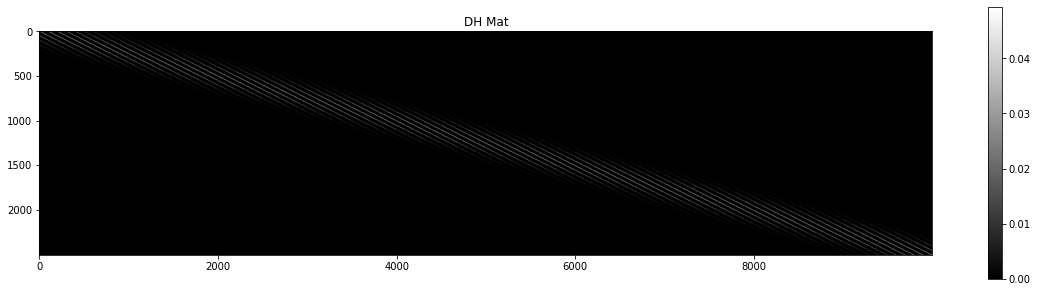

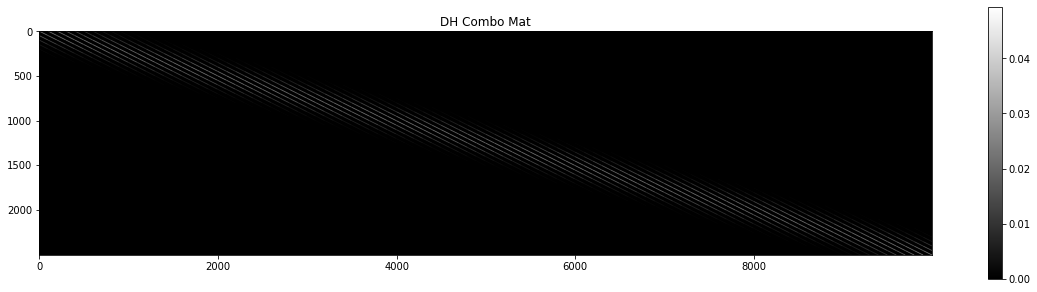

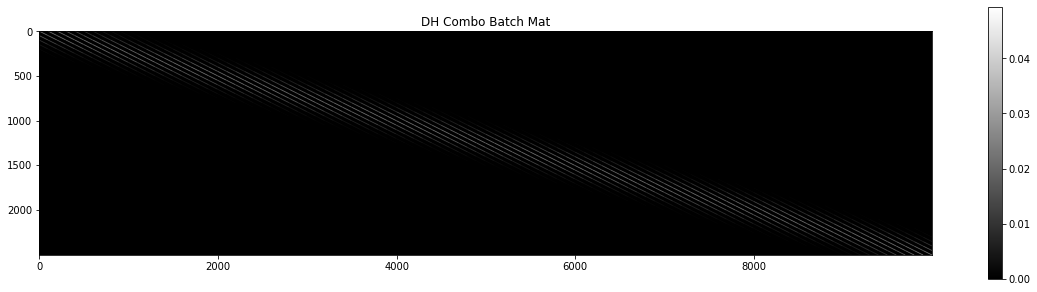

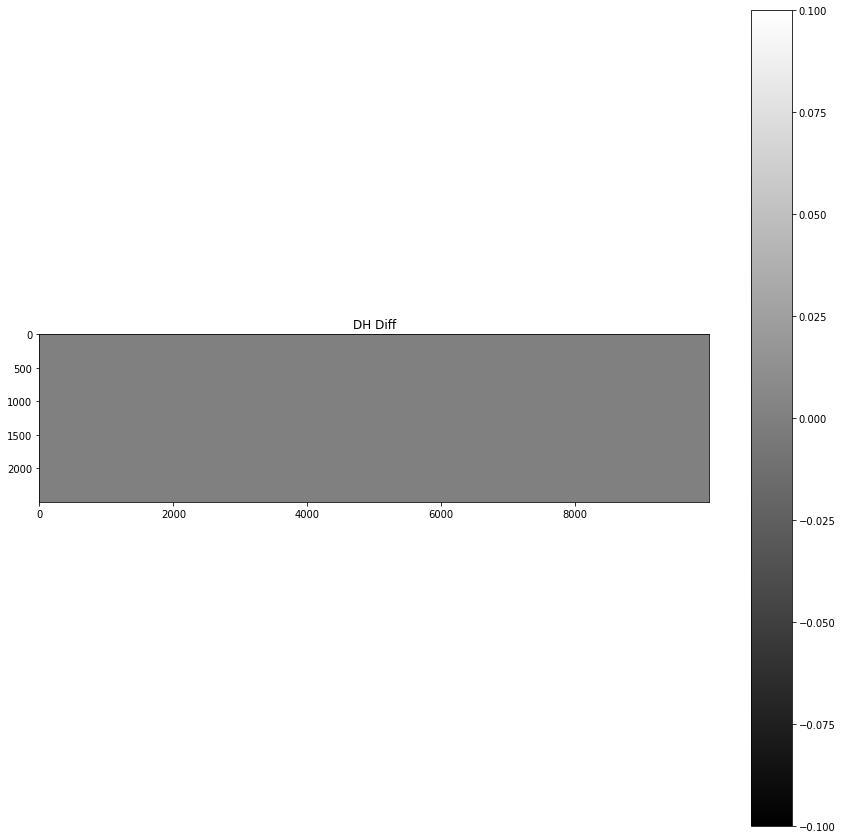

In [7]:
# # Original method of producing decimation matrix D
d = generate_d_matrix(high_res_dim, downsample)
# show_image(d.todense(), "D Matrix")

h = generate_h_matrix(high_res_dim, kernel)
# show_image(h.todense(), "H Matrix")

dh = d @ h
# show_sparse_matrix(dh, "DH Matrix")
show_image(dh.todense(), "DH Mat", fig_height=5, fig_width=20)

# New approach which produces DH without independent matrices D and H
dh_combo = generate_dh_matrix(kernel, high_res_dim, downsample)
show_image(dh_combo.todense(), "DH Combo Mat",  fig_height=5, fig_width=20)

dh_combo_batch = generate_dh_matrix_batched(kernel, high_res_dim, downsample, (low_res_dim**2)//2)
show_image(dh_combo_batch.todense(), "DH Combo Batch Mat",  fig_height=5, fig_width=20)

dh_diff = dh_combo - dh_combo_batch
show_image(dh_diff.todense(), "DH Diff")

# show_image((dh.todense() - m.todense()), "Diff")
# print((dh.power(2.0)).sum() - (m.power(2.0)).sum())

In [8]:
# def matrix_edge_exclusion_mask(current_index, high_res_dim, kernel_dim):
#     current_row = current_index // high_res_dim
#     current_col = current_index % high_res_dim
#     pixels = np.arange(kernel_dim**2) + current_index - 5
#     print(pixels.reshape(kernel_dim, kernel_dim))
#     mask = np.ones((kernel_dim, kernel_dim))
    
#     row_neighbours = np.arange(current_row, current_row + kernel_dim) - ((kernel_dim-1)//2)
#     print(row_neighbours)
    
#     col_neighbours = np.arange(current_col, current_col + kernel_dim) - ((kernel_dim-1)//2)
#     print(col_neighbours)
    
#     mask[(row_neighbours < 0) | (row_neighbours >= high_res_dim), :] = 0
#     mask[:, (col_neighbours < 0) | (col_neighbours >= high_res_dim)] = 0
#     return mask

# m = matrix_edge_exclusion_mask(1, 4, 2**2)
# print(m)
    
# # hr = 4
# # lr = 2
# # ks = 3
# # ds = hr // lr
# # row_offset = 2
# # indices = np.arange((ks+ds-1)**2) - 5
# # print(indices.reshape(4, 4))

# # rows = np.arange(-1, 4)
# # print(rows)
# # cols = np.arange(-1, 4)

# # mask = np.ones((5, 5), dtype=np.intc)
# # # print(mask)
# # mask[(rows < 0) | (rows > 1)] = 0
# # # print(mask)
# # mask[:, cols < 0] = 0
# # # print(mask)